<a href="https://colab.research.google.com/github/spowers42/deep_learning_demo_notebooks/blob/master/tinyML/SineWaveApproximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sine Wave approximator for edge computing experiments


In [1]:
!pip install -U tensorflow 

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

In [0]:
SEED = 42
SAMPLES = 1000
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Generate data

In [0]:
all_x = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
np.random.shuffle(all_x)
all_y = np.sin(all_x)
# add noise to y
all_y += 0.1*np.random.randn(*all_y.shape)

x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.4)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5)

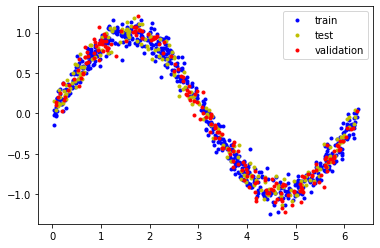

In [5]:
plt.plot(x_train, y_train, 'b.', label='train')
plt.plot(x_test, y_test, 'y.', label='test')
plt.plot(x_validation, y_validation, 'r.', label='validation')
plt.legend()

## Model architecture

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

In [0]:
def get_model(neurons=16, activation='relu'):
  inputs = Input(shape=(1,))
  layer1 = Dense(neurons, activation=activation)(inputs)
  layer2 = Dense(neurons, activation=activation)(layer1)
  output = Dense(1, activation='linear')(layer2)
  return Model(inputs=inputs, outputs=output)


In [8]:
model = get_model()
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(x_train, y_train, epochs=600, batch_size=16, validation_data=(x_validation, y_validation))

Train on 600 samples, validate on 200 samples
Epoch 1/600
600/600 [==============================] - 1s 1ms/sample - loss: 0.4770 - mae: 0.6081 - val_loss: 0.3952 - val_mae: 0.5420
Epoch 2/600
600/600 [==============================] - 0s 157us/sample - loss: 0.3880 - mae: 0.5372 - val_loss: 0.3439 - val_mae: 0.5020
Epoch 3/600
600/600 [==============================] - 0s 154us/sample - loss: 0.3417 - mae: 0.5052 - val_loss: 0.2937 - val_mae: 0.4582
Epoch 4/600
600/600 [==============================] - 0s 155us/sample - loss: 0.2998 - mae: 0.4726 - val_loss: 0.2524 - val_mae: 0.4239
Epoch 5/600
600/600 [==============================] - 0s 151us/sample - loss: 0.2523 - mae: 0.4377 - val_loss: 0.2073 - val_mae: 0.3862
Epoch 6/600
600/600 [==============================] - 0s 165us/sample - loss: 0.2117 - mae: 0.4001 - val_loss: 0.1763 - val_mae: 0.3574
Epoch 7/600
600/600 [==============================] - 0s 185us/sample - loss: 0.1878 - mae: 0.3789 - val_loss: 0.1541 - val_mae: 0.33

In [0]:
def plot_history(value='loss', start_offset=0):
  loss = history.history[value][start_offset:]
  val_loss = history.history['val_{}'.format(value)][start_offset:]
  epochs = range(1, len(loss)+1)
  plt.plot(epochs, loss, 'g.', label='loss')
  plt.plot(epochs, val_loss, 'b.', label='validation')
  plt.legend()
  plt.show()

In [0]:
def plot_predictions(x, y, model):
  predictions = model.predict(x)
  plt.plot(x, y, 'b.', label='truth')
  plt.plot(x, predictions, 'r.', label='predicted')
  plt.legend()
  plt.show()

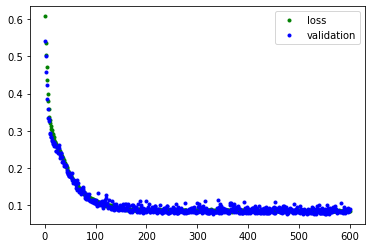

In [12]:
plot_history(value='mae')

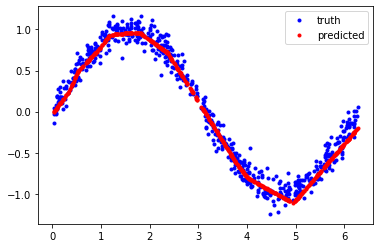

In [13]:
plot_predictions(x_train, y_train, model)

## Test model performance

200/200 [==============================] - 0s 116us/sample - loss: 0.0128 - mae: 0.0905


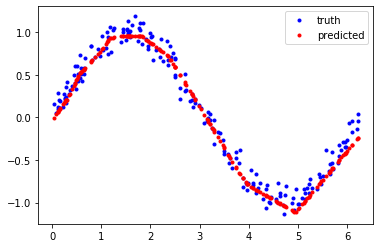

In [14]:
loss = model.evaluate(x_test, y_test)
plot_predictions(x_test, y_test, model)

## Prepare for deployment on device


In [0]:
def representative_dataset():
  for value in x_test:
    yield [np.array(value, dtype=np.float32, ndmin=2)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()
with open('sine_model.tflite', 'wb') as file:
  file.write(tflite_model)

## Validate TF lite model

In [0]:
tf_lite_model = tf.lite.Interpreter('sine_model.tflite')
tf_lite_model.allocate_tensors()
sine_model_input_idx = tf_lite_model.get_input_details()[0]['index']
sine_model_output_idx = tf_lite_model.get_output_details()[0]['index']

tf_lite_predictions = []
for x_value in x_test:
  x_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  tf_lite_model.set_tensor(sine_model_input_idx, x_tensor)
  tf_lite_model.invoke()
  tf_lite_predictions.append(tf_lite_model.get_tensor(sine_model_output_idx)[0])



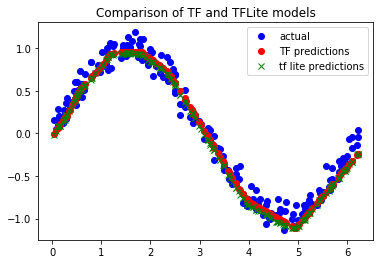

In [22]:
plt.clf()
plt.title("Comparison of TF and TFLite models")
plt.plot(x_test, y_test, 'bo', label='actual')
plt.plot(x_test, model.predict(x_test), 'ro', label='TF predictions')
plt.plot(x_test, tf_lite_predictions, 'gx', label='tf lite predictions')
plt.legend()

# Convert to a C compabitible file

In [26]:
!apt -qq install xxd
!xxd -i sine_model.tflite > sine_model.cc

xxd is already the newest version (2:8.0.1453-1ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [27]:
!cat sine_model.cc

unsigned char sine_model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x58, 0x09, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00, 0x90, 0x02, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x04, 0x00, 0x08, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x0b, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x48, 0x02, 0x00, 0x00, 0x34, 0x02, 0x00, 0x00,
  0x1c, 0x01, 0x00, 0x00, 0xfc, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,


## Colab download
Download the generated tflite file from colab.  Don't run this section if running local.  

In [0]:
from google.colab import files
files.download('sine_model.tflite')
files.download('sine_model.cc')